# Cluster and summarize long-form audio using STT and GenAI

## Solution Overview

<p align="center">
  <img alt="Conceptual Flow" src="Screenshot 2023-08-24 at 12.33.59 PM.png" width="100%">
</p>

## Setup

### Installs

In [1]:
# Install Vertex AI LLM SDK, langchain and dependencies
!pip install google-cloud-aiplatform vertexai langchain chromadb pydantic typing-inspect typing_extensions pandas datasets google-api-python-client pypdf faiss-cpu transformers config --upgrade --quiet

In [2]:
# # Automatically restart kernel after installs so that your environment can access the new packages
#import IPython

#app = IPython.Application.instance()
#app.kernel.do_shutdown(True)

### Imports

In [3]:
from datetime import datetime
import time
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import networkx as nx
from networkx.algorithms import community

from IPython.display import Markdown

from langchain.llms import VertexAI
from langchain.embeddings import VertexAIEmbeddings
from langchain.schema import HumanMessage, SystemMessage
from langchain.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain

import vertexai
from vertexai.language_models import TextGenerationModel, TextEmbeddingModel
from vertexai.preview.language_models import TextGenerationModel as TextGenerationModel_preview
from google.cloud import aiplatform
from google.cloud import storage
from google.cloud import bigquery

print("Vertex AI version: " + str(aiplatform.__version__))

2023-09-13 10:43:12.688447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Vertex AI version: 1.32.0


### Env variables and Setup

In [4]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'mg-ce-demos'

In [5]:
REGION = 'us-central1'
LOCATION = 'us'
GCS_BUCKET = PROJECT_ID
BLOB_PATH = 'audio_data/test'

In [6]:
DATASET = 'stt_genai'
TRANSCRIPT_TABLE_V1 = 'transcript_stt_genai_demo_v1'
TRANSCRIPT_TABLE_CHIRP = 'transcript_stt_genai_demo_chirp'
SUMMARY_TABLE = 'summary_stt_genai_demo'

In [7]:
# gcs client
gcs = storage.Client(project = PROJECT_ID)

# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

### Functions

In [8]:
# get audio data from GCS
def get_audio_data(gcs_bucket, blob_path):
    bucket = gcs.bucket(gcs_bucket)

    # Get the list of blobs
    blobs = bucket.list_blobs()

    # Loop through the blobs
    audio_data = []
    for blob in blobs:
        if blob.name.startswith(blob_path):
            if blob.name.endswith('.mp3'):
                #print(blob.name)
                audio_data.append([blob.name, blob.content_type, f'gs://{GCS_BUCKET}/{blob.name}'])
                
    return {
        'data_name': audio_data[-1][0],
        'data_type': audio_data[-1][1],
        'data_uri': audio_data[-1][2]
    }

In [9]:
# STT using cloud speech v2
from google.api_core.client_options import ClientOptions
from google.cloud.speech_v2 import SpeechClient as SpeechClient_v2
from google.cloud.speech_v2.types import cloud_speech as cloud_speech_v2

def transcribe_gcs_v2(gcs_uri: str) -> str:
    TIMEOUT_DEFAULT = 3600

    # Instantiates a client
    client = SpeechClient_v2(
        client_options=ClientOptions(
            api_endpoint="us-central1-speech.googleapis.com",
        )
    )
    
    config = cloud_speech_v2.RecognitionConfig(
        auto_decoding_config=cloud_speech_v2.AutoDetectDecodingConfig(),
        language_codes=["en-US"],
        model="chirp",
    )
    
    file_metadata = cloud_speech_v2.BatchRecognizeFileMetadata(uri=gcs_uri)

    request = cloud_speech_v2.BatchRecognizeRequest(
        recognizer=f"projects/{PROJECT_ID}/locations/{REGION}/recognizers/chirp-recognizer",
        config=config,
        files=[file_metadata],
        recognition_output_config=cloud_speech_v2.RecognitionOutputConfig(
            inline_response_config=cloud_speech_v2.InlineOutputConfig(),
        ),
    )

    # Transcribes the audio into text
    operation = client.batch_recognize(request=request)

    print("Waiting for operation to complete...")
    try:
        response = operation.result(timeout=TIMEOUT_DEFAULT)       # The default is 3600 seconds, 1 hour

    except:
        response = operation.result(timeout=1.5 * TIMEOUT_DEFAULT) # 5400 seconds, 1 hour and 30 minutes

    finally:
        response = operation.result(timeout=2 * TIMEOUT_DEFAULT)   # 7200 seconds, 2 hours

    return response


In [10]:
# create sentences and chunks for prompting
def create_sentences(segments, MIN_WORDS, MAX_WORDS):

    # Combine the non-sentences together
    sentences = []

    is_new_sentence = True
    sentence_length = 0
    sentence_num = 0
    sentence_segments = []

    for i in range(len(segments)):
        if is_new_sentence == True:
            is_new_sentence = False
        # Append the segment
        sentence_segments.append(segments[i])
        segment_words = segments[i].split(' ')
        sentence_length += len(segment_words)

        # If exceed MAX_WORDS, then stop at the end of the segment
        # Only consider it a sentence if the length is at least MIN_WORDS
        if (sentence_length >= MIN_WORDS and segments[i][-1] == '.') or sentence_length >= MAX_WORDS:
            sentence = ' '.join(sentence_segments)
            sentences.append({
            'sentence_num': sentence_num,
            'text': sentence,
            'sentence_length': sentence_length
            })
            # Reset
            is_new_sentence = True
            sentence_length = 0
            sentence_segments = []
            sentence_num += 1

    return sentences

def create_chunks(sentences, CHUNK_LENGTH, STRIDE):

    sentences_df = pd.DataFrame(sentences)

    chunks = []
    for i in range(0, len(sentences_df), (CHUNK_LENGTH - STRIDE)):
        chunk = sentences_df.iloc[i:i+CHUNK_LENGTH]
        chunk_text = ' '.join(chunk['text'].tolist())

        chunks.append({
            'start_sentence_num': chunk['sentence_num'].iloc[0],
            'end_sentence_num': chunk['sentence_num'].iloc[-1],
            'text': chunk_text,
            'num_words': len(chunk_text.split(' '))
        })
    
    chunks_df = pd.DataFrame(chunks)
    return chunks_df.to_dict('records')

def parse_title_summary_results(results):
    out = []
    for e in results:
        e = e.replace('\n', '')
        if '|' in e:
            processed = {'title': e.split('|')[0],
                        'summary': e.split('|')[1][1:]
                        }
        elif ':' in e:
            processed = {'title': e.split(':')[0],
                        'summary': e.split(':')[1][1:]
                        }
        elif '-' in e:
            processed = {'title': e.split('-')[0],
                        'summary': e.split('-')[1][1:]
                        }
        else:
            processed = {'title': '',
                        'summary': e
                        }
        out.append(processed)
    return out

In [11]:
# GenAI summary stage 1 using raw text chunks
def summary_stage_1(chunks_text):
    
    start_time = time.time()

    # Prompt to get title and summary for each chunk
    map_prompt_template = """Summarize the key points of the following text. Include as much information as possible:

    {text}"""

    map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

    # Define the LLMs
    map_llm = VertexAI(model_name="text-bison-32k",
        max_output_tokens=1024,
        temperature=0.4,
        top_p=0.8,
        top_k=40,
        verbose=True,)
    map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
    map_llm_chain_input = [{'text': t} for t in chunks_text]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

    stage_1_outputs_summary = [e['text'] for e in map_llm_chain_results]

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'Summary creation - Stage 1: {total_time} minutes')

    return {
        'stage_1_outputs_summary': stage_1_outputs_summary
    }

In [12]:
# Run the community detection algorithm to determine distinct topics
def get_topics(stage_1_summaries, num_1_chunks, num_topics = 8, bonus_constant = 0.25, min_size = 3):
    # Use Vertex AI to embed the summaries and titles. Size of _embeds: (num_chunks x 768)
    vertex_embed = VertexAIEmbeddings()

    summary_embeds = np.array(vertex_embed.embed_documents(stage_1_summaries))
    
    # Get similarity matrix between the embeddings of the chunk summaries
    summary_similarity_matrix = np.zeros((num_1_chunks, num_1_chunks))
    summary_similarity_matrix[:] = np.nan

    for row in range(num_1_chunks):
        for col in range(row, num_1_chunks):
            # Calculate cosine similarity between the two vectors
            similarity = 1- cosine(summary_embeds[row], summary_embeds[col])
            summary_similarity_matrix[row, col] = similarity
            summary_similarity_matrix[col, row] = similarity
    
    # Draw a heatmap with the summary_similarity_matrix
    plt.figure()
    # Color scheme blues
    plt.imshow(summary_similarity_matrix, cmap = 'Blues')
    
    title_similarity = summary_similarity_matrix

    proximity_bonus_arr = np.zeros_like(title_similarity)
    for row in range(proximity_bonus_arr.shape[0]):
        for col in range(proximity_bonus_arr.shape[1]):
            if row == col:
                proximity_bonus_arr[row, col] = 0
            else:
                proximity_bonus_arr[row, col] = 1/(abs(row-col)) * bonus_constant
        
    title_similarity += proximity_bonus_arr

    title_nx_graph = nx.from_numpy_array(title_similarity)

    desired_num_topics = num_topics
    # Store the accepted partitionings
    topics_title_accepted = []

    resolution = 0.85
    resolution_step = 0.01
    iterations = 40

    # Find the resolution that gives the desired number of topics
    topics_title = []
    while len(topics_title) not in [desired_num_topics, desired_num_topics + 1, desired_num_topics + 2]:
        topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
        resolution += resolution_step
    topic_sizes = [len(c) for c in topics_title]
    sizes_sd = np.std(topic_sizes)
    modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)

    lowest_sd_iteration = 0
    # Set lowest sd to inf
    lowest_sd = float('inf')

    for i in range(iterations):
        topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
        modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)

        # Check SD
        topic_sizes = [len(c) for c in topics_title]
        sizes_sd = np.std(topic_sizes)

        topics_title_accepted.append(topics_title)

        if sizes_sd < lowest_sd and min(topic_sizes) >= min_size:
            lowest_sd_iteration = i
            lowest_sd = sizes_sd
      
    # Set the chosen partitioning to be the one with highest modularity
    topics_title = topics_title_accepted[lowest_sd_iteration]
    print(f'Best SD: {lowest_sd}, Best iteration: {lowest_sd_iteration}, Number of topics (actual): {len(topics_title)}, Number of topics (setting): {desired_num_topics}')

    topic_id_means = [sum(e)/len(e) for e in topics_title]
    # Arrange title_topics in order of topic_id_means
    topics_title = [list(c) for _, c in sorted(zip(topic_id_means, topics_title), key = lambda pair: pair[0])]
    # Create an array denoting which topic each chunk belongs to
    chunk_topics = [None] * title_similarity.shape[0]
    for i, c in enumerate(topics_title):
        for j in c:
            chunk_topics[j] = i
            
    return {
        'chunk_topics': chunk_topics,
        'topics': topics_title
    }

In [13]:
# GenAI summary stage 2 referencing topics and creation of articles
def summary_stage_2(summary_data, topics, summary_num_words = 250):
    
    start_time = time.time()
  
    # Prompt to get title and summary for each chunk
    MAP_PROMPT_TEMPLATE = """Write a """ + str(summary_num_words) + """ word summary of the following text.  Include as much information as possible:
  
    {text}
    """
    
    map_prompt = PromptTemplate(template=MAP_PROMPT_TEMPLATE, input_variables=["text"])

    # Define the LLMs
    map_llm = VertexAI(model_name="text-bison-32k",
        max_output_tokens=512,
        temperature=0.4,
        top_p=0.8,
        top_k=40,
        verbose=True,)
  
    topics_data = []
    for c in topics:
        topic_data_temp = [stage_1_summaries[chunk_id] for chunk_id in c]
        topic_data_temp = '. '.join(topic_data_temp)
        topics_data.append(topic_data_temp)

    map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
    map_llm_chain_input = [{'text': t} for t in topics_data]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

    stage_2_outputs_summary = [e['text'] for e in map_llm_chain_results]

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'Summary creation - Stage 2: {total_time} minutes')

    return {
        'stage_2_outputs_summary': stage_2_outputs_summary
    }

def title_stage_2(summary_data, topics, summary_num_words = 250):
    
    start_time = time.time()

    # Prompt to get title and summary for each chunk
    MAP_PROMPT_TEMPLATE = """Write a short title of the following text.  Do not include an explanation:

    {text}
    """

    map_prompt = PromptTemplate(template=MAP_PROMPT_TEMPLATE, input_variables=["text"])

    # Define the LLMs
    map_llm = VertexAI(model_name="text-bison-32k",
        max_output_tokens=256,
        temperature=0.4,
        top_p=0.8,
        top_k=40,
        verbose=True,)
        
    map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
    map_llm_chain_input = [{'text': t} for t in summary_data]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

    stage_2_outputs_title = [e['text'] for e in map_llm_chain_results]

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'Title creation - Stage 2: {total_time} minutes')

    return {
        'stage_2_outputs_title': stage_2_outputs_title
    }

def article_stage_2(stage_1_summaries, num_drafts=1):
    # set number of drafts to generate
    NUM_DRAFTS = num_drafts

    # Query Palm 2 to get a summary and title for each topic
    drafts = []
    for i in range(0, NUM_DRAFTS):
        print(f"Draft {i}")
        stage_2_outputs_summary = summary_stage_2(stage_1_summaries, topics, summary_num_words = 250)['stage_2_outputs_summary']
        stage_2_outputs_title = title_stage_2(stage_2_outputs_summary, topics, summary_num_words = 250)['stage_2_outputs_title']
        drafts.append([i+1, stage_2_outputs_title, stage_2_outputs_summary])
    
    return {
        'drafts': drafts
    }

## Data: Get data from GCS

Can loop through GCS to pick up multiple files.  This iteration is built for one file at a time but easy to update.

Loop through GCS bucket(s) for audio files to transcribe

In [14]:
sample_uri = get_audio_data(GCS_BUCKET, BLOB_PATH)['data_uri']
print(sample_uri)

gs://mg-ce-demos/audio_data/test/Mapping_uncharted_undersea_volcanoes,_and_elephant_seals_dive_deep_to_sleep.mp3


## Data: Transcribe audio and stringify

Until we can associate specific comments with specific people (e.g. using something like Speaker ID), speaker diarization doesn't add much value.  In v2, this was removed so we could test with the new Chirp model which did appear to improve accuracy of the transcription.

Function to transcribe audio, including speaker diarization and other features

In [15]:
## BQ table check
from google.cloud.exceptions import NotFound

table_id = f"{PROJECT_ID}.{DATASET}.{TRANSCRIPT_TABLE_CHIRP}"

prior_transcription=False
try:
    bq.get_table(table_id)  # Make an API request.
    print("Table {} already exists.".format(table_id))
    if bq.query(f"SELECT COUNT(*) FROM {table_id}").result().total_rows == 0:
        print("The table is empty")
        start_time = time.time()

        response = transcribe_gcs_v2(sample_uri)
        
        order = 0

        transcript_df2 = pd.DataFrame(columns=['file', 'order', 'text'])

        for result in response.results[sample_uri].transcript.results:
            transcript_df2.loc[len(transcript_df2.index)] = [sample_uri, order, result.alternatives[0].transcript]
            order += 1

        transcript_df2.head()
        transcript_string = transcript_df2['text'].str.cat(sep=' ')

        table_id = f'{PROJECT_ID}.{DATASET}.{TRANSCRIPT_TABLE_CHIRP}'

        job_config = bigquery.LoadJobConfig(
            write_disposition=bigquery.job.WriteDisposition.WRITE_TRUNCATE
        )

        job = bq.load_table_from_dataframe(
            transcript_df2, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        table = bq.get_table(table_id)  # Make an API request.
        print(
            "Loaded {} rows and {} columns to {}".format(
                table.num_rows, len(table.schema), table_id
            )
        )

        end_time = time.time()
        total_time = (end_time - start_time)/60
        print(f'{total_time} minutes')
    else:
        print("The table is not empty")
        prior_transcription=True
        query = """
        SELECT
          *
        FROM `{0}`
        """.format(table_id)
        transcript_df2 = bq.query(query).to_dataframe()
        transcript_df2 = transcript_df2.sort_values(by=['order'])
        transcript_string = transcript_df2['text'].str.cat(sep=' ')
        transcript_string = transcript_string.replace('a.m.', 'am')
        transcript_string = transcript_string.replace('p.m.', 'pm')
        transcript_string = transcript_string.replace('.com', ' dot com')

except NotFound:
    print("Table {} is not found.".format(table_id))
    start_time = time.time()

    response = transcribe_gcs_v2(sample_uri)
    
    order = 0

    transcript_df2 = pd.DataFrame(columns=['file', 'order', 'text'])

    for result in response.results[sample_uri].transcript.results:
        transcript_df2.loc[len(transcript_df2.index)] = [sample_uri, order, result.alternatives[0].transcript]
        order += 1
        
    transcript_df2.head()
    transcript_string = transcript_df2['text'].str.cat(sep=' ')
    transcript_string = transcript_string.replace('a.m.', 'am')
    transcript_string = transcript_string.replace('p.m.', 'pm')
    transcript_string = transcript_string.replace('.com', ' dot com')
    transcript_string = transcript_string.replace('.org', ' dot org')
    
    table_id = f'{PROJECT_ID}.{DATASET}.{TRANSCRIPT_TABLE_CHIRP}'

    job_config = bigquery.LoadJobConfig(
        write_disposition=bigquery.job.WriteDisposition.WRITE_TRUNCATE
    )

    job = bq.load_table_from_dataframe(
        transcript_df2, table_id, job_config=job_config
    )
    job.result()  # Wait for the job to complete.
    table = bq.get_table(table_id)  # Make an API request.
    print(
        "Loaded {} rows and {} columns to {}".format(
            table.num_rows, len(table.schema), table_id
        )
    )

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'{total_time} minutes')


Table mg-ce-demos.stt_genai.transcript_stt_genai_demo_chirp already exists.
The table is not empty


Build transcription, by speaker, grabbing words passing the confidence threshold

In [16]:
len(transcript_string)

35973

## 32K Model Summarization Test

In [17]:
textgen_model_32k = TextGenerationModel_preview.from_pretrained('text-bison-32k')

In [18]:
transcript_string_32k = transcript_string[0:30000]
len(transcript_string_32k)

30000

In [19]:
# 32k model summarization test
# Ask the LLM
prompt = """Summarize the key points of the text below.  Write the summary in bullet form with 1-2 sentences per key point.

Text:
{}""".format(transcript_string_32k)

# Send prompt to LLM
response_32k = textgen_model_32k.predict(
   (prompt),
    max_output_tokens=2000,
    temperature=0.4,
    top_p=0.8,
    top_k=40,
)
display(Markdown(str(response_32k)))

 - The number of known seamounts nearly doubled to 19,000 with the help of radar-equipped satellites that measure the height of the ocean worldwide. 
 - Seamounts are important because they provide unique habitats for sea life, can affect ocean circulation, and are potential hazards for submarines and ships. 
 - Elephant seals can sleep while diving underwater by flipping upside down and spinning in a circle. 
 - This behavior allows them to get deep sleep while still being able to breathe. 
 - Researchers used sleep monitors and motion sensors to study the sleep patterns of elephant seals in the wild. 
 - Addiction is a chronic mental health condition that affects millions of people worldwide. 
 - It is defined as a compulsive behavior that persists despite negative consequences. 
 - The number of addiction-related deaths has increased dramatically in recent years, with over 100,000 Americans dying each year from drug overdoses. 
 - The science of addiction has advanced significantly in recent years, with researchers gaining a better understanding of the neurobiology of addiction and the factors that contribute to it. 
 - New treatments for addiction are being developed based on this research, with the goal of helping people overcome this devastating disorder.

## Create sentences and chunks

After transcription, we need to isolate sentences, and create chunks of content.  Unlikely we will get much meaningful context from individual sentences.  Also, we don't want to lose context through chunking so we also will overlap when we combine sentences (i.e. sentences->chunks 1-2-3-4, 2-3-4-5, 3-4-5-6)

In [20]:
# Get segments from txt by splitting on .
segments =  transcript_string.split('.')
# Put the . back in
segments = [segment + '.' for segment in segments]
# Further split by comma
#segments = [segment.split(',') for segment in segments]
# Flatten
#segments = [item for sublist in segments for item in sublist]

In [21]:
# define chunk size and overlap
sentences = create_sentences(segments, MIN_WORDS=10, MAX_WORDS=100)
chunks = create_chunks(sentences, CHUNK_LENGTH=5, STRIDE=1)
chunks_text = [chunk['text'] for chunk in chunks]

In [22]:
print(len(chunks_text))
#chunks_text

33


## Stage 1: Get Chunk Summaries

Now we create our first summaries and titles based on the chunks of sentences we created from the transcriptions.  This is done using langchain and chaining prompts to create the summary and subsequently the titles.  These can be accomplished in a single step but I found the outputs not as good as doing them sequentially.

### v2

In [23]:
# Run Stage 1 Summarizing
stage_1_summaries = summary_stage_1(chunks_text)['stage_1_outputs_summary']

Summary creation - Stage 1: 5.053415668010712 minutes


In [24]:
# minor data cleanup
stage_1_summaries = [" " if x == '' else x for x in stage_1_summaries]
stage_1_summaries = [string.replace('\n', ' ') for string in stage_1_summaries]

## Generate embeddings for titles and summaries, and cluster into distinct topics

Using the stage 1 summaries, now we group them into common topics using cosine similarity and Louvain community detection.  This is necessary as the content contains many different topics, which when combining will make it hard for LLMs to produce concise content.  This step in the process produces the final context for creating final summaries / articles for each topic.

Best SD: 0.9270248108869579, Best iteration: 1, Number of topics (actual): 8, Number of topics (setting): 8


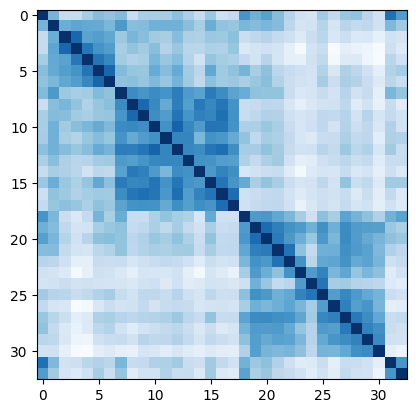

In [25]:
# Set num_topics to be 1/4 of the number of chunks, or 12, which ever is smaller
num_1_chunks = len(stage_1_summaries)
NUM_TOPICS = min(int(num_1_chunks / 4), 12)
topics_out = get_topics(stage_1_summaries, num_1_chunks, num_topics = NUM_TOPICS, bonus_constant = 0.3)
chunk_topics = topics_out['chunk_topics']
topics = topics_out['topics']

In [26]:
topics

[[1, 2, 3, 4, 5, 6],
 [8, 9, 7],
 [10, 11, 12, 13],
 [16, 17, 14, 15],
 [18, 19, 20, 21],
 [32, 0, 31],
 [24, 25, 22, 23],
 [26, 27, 28, 29, 30]]

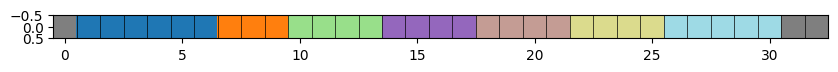

In [27]:
# Plot a heatmap of this array
plt.figure(figsize = (10, 4))
plt.imshow(np.array(chunk_topics).reshape(1, -1), cmap = 'tab20')
# Draw vertical black lines for every 1 of the x-axis 
for i in range(1, len(chunk_topics)):
    plt.axvline(x = i - 0.5, color = 'black', linewidth = 0.5)

## Stage 2: Final Summaries

Using the topics identified prior to this step, we use the same prompt chaining approach to create a summary then title for each topic.  At this point, we have a **first draft** for each topic where the LLM was able to produce an informative article and title.

### v2

In [28]:
drafts = article_stage_2(stage_1_summaries, num_drafts=1)['drafts']

Draft 0
Summary creation - Stage 2: 1.539211599032084 minutes
Title creation - Stage 2: 0.9943151036898296 minutes


In [45]:
display(Markdown('# DRAFT direct 32K summarization'))
display(Markdown(str(response_32k)))

# DRAFT direct 32K summarization

 - The number of known seamounts nearly doubled to 19,000 with the help of radar-equipped satellites that measure the height of the ocean worldwide. 
 - Seamounts are important because they provide unique habitats for sea life, can affect ocean circulation, and are potential hazards for submarines and ships. 
 - Elephant seals can sleep while diving underwater by flipping upside down and spinning in a circle. 
 - This behavior allows them to get deep sleep while still being able to breathe. 
 - Researchers used sleep monitors and motion sensors to study the sleep patterns of elephant seals in the wild. 
 - Addiction is a chronic mental health condition that affects millions of people worldwide. 
 - It is defined as a compulsive behavior that persists despite negative consequences. 
 - The number of addiction-related deaths has increased dramatically in recent years, with over 100,000 Americans dying each year from drug overdoses. 
 - The science of addiction has advanced significantly in recent years, with researchers gaining a better understanding of the neurobiology of addiction and the factors that contribute to it. 
 - New treatments for addiction are being developed based on this research, with the goal of helping people overcome this devastating disorder.

In [46]:
for i in range(len(drafts)):
    display(Markdown('# DRAFT ' + str(drafts[i][0])))
    for j in range(len(drafts[i][1])):
        if drafts[i][1][j] != "":
            if drafts[i][2][j] != "":
                display(Markdown('### ' + drafts[i][1][j]))
                display(Markdown(drafts[i][2][j]))
                #print(drafts[i][2][j])
                print('------------------------')

# DRAFT 1

###  Sarah Cresty Show: New seamounts discovered; elephant seal sleep; addiction research

 Sarah Cresty hosts a show about the discovery of 19,000 new seamounts, bringing the total number known to 21,500. The new seamounts were found using improved satellite data, which allowed scientists to see smaller seamounts than before. Seamounts are underwater volcanoes that are at least 1 kilometer high. They are important because they provide habitats for a variety of sea life and act as stepping stones for marine life to migrate across the ocean. The new global map of seamounts will help scientists better understand their role in the ocean and protect these important ecosystems.  In the first segment, Sarah Cresty interviews Paulsen about a study that nearly doubled the number of known seamounts. In the second segment, Sarah Cresty interviews Jessica Kendle Bar about her work exploring the sleep of elephant seals. In a sponsored segment, Jackie Oburst talks with addiction researchers Eric Nestler and Paul Kenny about what researchers have discovered about addiction over the last 5 years.

------------------------


###  Sleep Patterns of Marine Mammals

 Elephant seals are marine mammals that spend most of their lives in the water. This makes it difficult for them to sleep deeply, as they need to come up for air regularly. To overcome this challenge, elephant seals have evolved a unique sleep pattern. They sleep in short bursts, taking turns sleeping while the others keep watch for predators. This allows them to get the rest they need while still being able to respond to danger.
     Other marine mammals, such as whales, dolphins, and seals, can also sleep in just half of their brain at a time. This is called unihemispheric sleep, and it allows them to keep one eye open and monitor predators while they are getting the benefits of sleep for half of their brain.
     The first night effect is a documented phenomenon where people are slightly more aware when they sleep in a new place. This is likely due to the fact that one hemisphere of the brain is more engaged in slow-wave sleep than the other.

------------------------


###  Elephant Seal Sleep Patterns in the Wild

 A study was conducted on elephant seals to observe their diving patterns and behavior in their natural environment. Researchers attached sleep monitors to the seals to collect data on their behavior, including depth and duration of dives. The study revealed that the seals spent a significant amount of time at extreme depths and held their breath for extended periods. 

The author used data-driven animations to visualize the seals' behavior underwater, showing their movements, pitch, roll, and frequency of swimming. The animations also captured the seals' unique sleep spirals. 

To measure the sleep behavior of seals, the author employed sensors similar to those used in human sleep studies. The author even tested the methods on himself, floating in shallow water and attempting to sleep. 

Due to the size and potential danger of elephant seals, researchers employed various methods to attach sensors to them, including sedation and the use of headcaps. The study revealed that elephant seals spend most of their time in a state of slow-wave sleep, and their sleep patterns are influenced by their environment, with seals in areas with more predators spending less time in deep sleep. 

The study also found that elephant seals can control their buoyancy while sleeping, allowing them to maintain their desired depth in the water without constant swimming. The research provides valuable insights into the sleep patterns of elephant seals and their adaptation to their environment. 

Additionally, the author's use of 3D motion sensors revealed that seals enter REM sleep while upside down and spinning in a circle, suggesting their ability to sleep while still moving, which is uncommon among ocean mammals.

------------------------


###  Sleep Patterns and Heart Rate Variability in Elephant Seals

 Elephant seals exhibit significant variation in their sleep patterns depending on their diving behavior.  When looking at the population as a whole,  "sleep dives" can be observed,  where the seals  sleep for short periods during their dives.  On average, elephant seals sleep for about two hours a day during long foraging trips, slightly less during shorter trips, and slightly more during extremely long trips.  However, there is a group of elephant seals that employ a different foraging strategy, traveling up the coast and diving much deeper. These seals perform only  three to ten  foraging dives a day and spend the rest of the time sleeping, sometimes up to 10 hours per day.  The heart rate of elephant seals also varies greatly,  ranging from as high as 200 beats per minute to as low as five beats per minute.  This flexibility in heart rate is likely related to the seals' diving behavior and their ability to lower their heart rate to conserve oxygen during dives.  The heart rate of seals can vary greatly depending on their age and how well they have developed their mammalian dive response, which allows them to lower their heart rate when diving.  Heart rates as high as 200 beats per minute and as low as five beats per minute have been recorded.  The lowest heart rates were recorded after the seals encountered a killer whale and immediately dove back down.  Studying the sleep patterns of seals in the wild is important for understanding how, where, and when they rest, and this information can be used to better manage and protect their critical resting habitats.

------------------------


###  Addiction: A Complex and Multifaceted Disease

 Summary:
  
Jessica Kendall Bar is a Schmitt AI and Science post-doctoral Fellow at the Scripps Institution of Oceanography at UC San Diego. She and her colleagues recently published a paper in Science magazine discussing the latest research on addiction. In the paper, Bar and her colleagues argue that addiction is a chronic disease that affects the brain and behavior. They also discuss the importance of understanding the underlying mechanisms of addiction in order to develop more effective treatments.  

Addiction is a chronic mental health condition that kills hundreds of thousands of Americans every year and impacts millions of lives. It can destroy marriages, friendships, and careers, and threaten a person's basic health and safety. Addiction is a medical problem that needs medical solutions.  

Dr. Nora Volkow, Director of the National Institute on Drug Abuse, and Dr. Charles O'Brien, Professor of Psychiatry at the University of Pennsylvania, are two renowned experts on addiction. They discuss the latest research on addiction and how it can be treated.  

Addiction is a complex and multifaceted disease that affects millions of people around the world. It is characterized by compulsive drug seeking and use, despite negative consequences. The science of addiction is a rapidly growing field, and new insights into the underlying mechanisms of addiction are emerging all the time.  

Dr. Eric Nessler and Dr. Paul Kenny are two renowned experts on addiction who will be discussing the latest research on addiction at an upcoming event. Dr. Nessler's laboratory studies the molecular mechanisms of drug addiction and depression in animal models. Dr. Kenny's research focuses on the development of new treatments for addiction.  

Addiction is a psychiatric syndrome that can only be diagnosed by talking to a person or their family members and finding out what types of abnormal behaviors they exhibit. Researchers define addiction in different ways, which is one of the major gaps in our knowledge.  

Dr. Eric Nestler and Dr. Paul Kenny are two researchers who study addiction. Dr. Nestler's research focuses on the molecular underpinnings of neurobehavioral disorders such as schizophrenia and drug addiction. Dr. Kenny's research involves the study of behavioral paradigms, physiological analyses, and the molecular underpinnings of neurobehavioral disorders such as schizophrenia and drug addiction.

------------------------


###  Science Podcast: The Science of Sound

 This week's Science Podcast explores the science of sound. The episode covers a range of topics related to sound, including how sound waves work, how we hear sound, and how sound can be used to create music and other forms of art. The episode is hosted by Sarah Cresby and Kevin McClain, and features music by Jeffrey Cook.
This episode of the Science Podcast is brought to you by the Icahn School of Medicine at Mount Sinai. Researchers at the Icahn School of Medicine are working to advance our understanding of the brain and improve care for disorders such as depression, dementia, and drug addiction. 
You can learn more about their work in a special supplement to Science magazine, prepared by Icahn Mount Sinai in partnership with Science. 
Visit www.science.org and search for "Frontiers of Medical Research-Brain Science."
The Science Podcast is a production of Science magazine, and is available on their website as well as on podcasting apps. 
Listener feedback is welcome at  SciencePodcast@aaas.org.

------------------------


###  The American Drug Epidemic

 Since the pandemic, the number of American fatalities from drug overdoses has skyrocketed, reaching an estimated 100,000 per year. This surpasses the number of American soldiers killed in the Vietnam War. The primary cause of this rise is the widespread use of opioids in the United States, but other drugs like cocaine and methamphetamine also contribute. 
     We have made great strides in understanding the science of addiction in recent years. Drugs that people abuse can activate the brain's reward pathways, causing changes that can result in addiction. Addiction is a chronic disease that necessitates medical attention. Diagnosis of addiction, a psychiatric condition, requires a conversation to identify abnormal behaviors as there is no definitive blood test, genetic test, or brain scan. 
     Addiction is a compulsive behavior that persists despite negative consequences and is aimed at obtaining drugs.  The consequences of addiction on society are severe. The opioid epidemic is a major contributor to premature death in the United States, claiming nearly 71,000 lives in 2019.  Addiction can result in higher crime rates, unemployment, lower educational attainment, increased healthcare expenses, social isolation, and mental health issues.

------------------------


###  Rewarding Pathways and Addiction

 Reward pathways are ancient parts of the brain that regulate responses to rewarding stimuli. Drugs of abuse hijack these pathways, creating an intensely rewarding experience without any actual benefit. This can lead to addiction, as the brain's reward system becomes corrupted and natural rewards are no longer satisfying. Addicted individuals require the powerful effects of drugs to feel normal. Drug abuse causes chemical changes in the brain that drive addiction, and genetic variations can influence the likelihood of drug use, addiction, and difficulty quitting. Medications like methadone and suboxone can be effective in treating opioid addiction, but new therapeutics are needed. Behavioral therapies are the mainstay of addiction treatment but have high relapse rates. Combining behavioral therapy with medication is currently the most effective treatment for substance use disorders.  Despite the challenges, most people eventually overcome addiction.

------------------------


## UI (WIP)

In [31]:
def upload_file(file):
    file_path = file.name
    file_name = os.path.basename(file_path)
    bucket = gcs.bucket(GCS_BUCKET)
    blob = bucket.blob(f'audio_data/cumulus/{file_name}')
    blob.upload_from_filename(f'{file_path}')
    #print("Uploaded")
    
    gcs_path = f'gs://{GCS_BUCKET}/{blob.name}'
    
    return gcs_path
    
#with gr.Blocks() as demo:
#    file_output = gr.File()
#    upload_button = gr.UploadButton("Click to Upload a File", file_types=["audio"])
#    upload_button.upload(upload_file, upload_button, file_output)

#demo.launch(share=False, debug=False)

In [32]:
# create a function that pulls all the steps together
def article_builder(gcs_uri):
    

IndentationError: expected an indented block (754168372.py, line 3)

In [ ]:
get_audio_data('mg-ce-demos')

In [ ]:
import gradio as gr

demo = gr.Blocks()

with demo:
    audio_file = gr.Audio(type="filepath")
    text = gr.Textbox()
    label = gr.Label()

    b1 = gr.Button("Upload")
    b2 = gr.Button("Get GCS URI")
    b3 = gr.Button("Create Articles")

    b1.click(upload_file, inputs=audio_file, outputs=text)
    b2.click(get_audio_data, inputs=text, outputs=label)

if __name__ == "__main__":
    demo.launch()

In [ ]:

with gr.Blocks() as demo:
    gr.Markdown(
    """
    ## Audio to Articles
    """)
    #with gr.Row():
    #    file_output = gr.File()
    #    upload_button = gr.UploadButton("Click to Transcribe and Draft Articles", file_types=["audio"])
    #    upload_button.upload(upload_file, upload_button, file_output)  
        
    with gr.Row():
        with gr.Column():
            input_text = gr.Textbox(label="Task", placeholder="Cloud Bucket Name")
    
    with gr.Row():
        find_gcs_uri = gr.Button("Select Audio File")
        
    with gr.Row():
        label1 = gr.Textbox(label="GCS URI")
        
    #with gr.Row():
    #    generate = gr.Button("Generate Response")

    #with gr.Row():
    #    label2 = gr.Textbox(label="Prompt")
    #with gr.Row():
    #    label3 = gr.Textbox(label="Response generated by LLM")

    generate.click(get_audio_data, input_text, label1)
    
demo.launch(share=False, debug=False)